# **Brewing a PLS regressor**

## **Introduction**
This dataset provides information on lignocellulosic ethanol fermentation through spectroscopic data collected data using attenuated total reflectance, mid-infrared (ATR-MIR) spectroscopy, along with reference measurements using high-performance liquid chromatography (HPLC) for validation.

The project contains two datasets:

- **Training Dataset:** Contains spectral data with corresponding HPLC measurements used to train the partial least squares (PLS) models.
- **Testing Dataset:** Includes a time series of spectra collected during fermentation, plus off-line HPLC measurements.

For more information about these datasets and how they can be used to monitor fermentation, please see our article: "Transforming Data to Information: A Parallel Hybrid Model for Real-Time State Estimation in Lignocellulosic Ethanol Fermentation." (Note that the data in the article differs from the data provided here.)

## **Objective**
In this exercise, you will build a PLS model to monitor glucose concentration in real-time using ATR-MIR spectroscopy. You'll train the model using a small training set of spiked spectra, then test its performance with spectra from an actual fermentation process.

## **Before starting**
Before we start, you need to be sure to have the following dependencies installed:

```
chemotools
matplotlib
numpy
pandas
```

You can install them using

```bash
pip install chemotools
pip install matplotlib
pip install numpy
pip install pandas
```

## **Loading the training data**
You can access the from the ```chemotools.datasets``` module with the ```load_fermentation_train()``` function.

In [1]:
from chemotools.datasets import load_fermentation_train

spectra, hplc = load_fermentation_train()

The ```load_fermentation_train()``` function returns two ```pandas.DataFrame```:

- ```spectra```: This dataframe contains spectral data, with columns representing wavenumbers and rows representing samples.

- ```hplc```: Here, you’ll find reference HPLC measurements for the glucose concentration (in g/L) of each sample, stored in a single column labeled ```glucose```.

**Note:**

If you are interested in working with ```polars.DataFrame``` you can simply use ```load_fermentation_train(set_output="polars")```. Note that if you choose to work with ```polars.DataFrame``` the wavenumbers are given in the column names as ```str``` and not as ```float```. This is because ```polars``` does not support column names with types other than ```str```. To extract the wavenumbers as ```float``` from the ```polars.DataFrame``` you can use the ```df.columns.to_numpy(dtype=np.float64)``` method.

## **Exploring the training data**
Before starting with data modeling, it’s important to get familiar with your data. Let's start by answering some basic questions: 

- *How many samples are there?* 
- *and how many wavenumbers are available?*

In [2]:
print(f"Number of samples: {spectra.shape[0]}")
print(f"Number of wavenumbers: {spectra.shape[1]}")

Number of samples: 21
Number of wavenumbers: 1047


Now that we have the basics down, let’s take a closer look at the data.

For the spectral data, you can use the ```pandas.DataFrame.head()``` method to examine the first 5 rows:

In [3]:
spectra.head()

,428.0,429.0,431.0,432.0,434.0,436.0,437.0,439.0,440.0,442.0,...,1821.0,1823.0,1824.0,1825.0,1826.0,1828.0,1829.0,1830.0,1831.0,1833.0
0,0.493506,-0.383721,0.356846,0.205714,0.217082,0.740331,0.581749,0.106719,0.507973,0.298643,...,0,0,0,0,0,0,0,0,0,0
1,0.108225,0.488372,-0.037344,0.448571,0.338078,0.632597,0.368821,0.462451,0.530752,0.221719,...,0,0,0,0,0,0,0,0,0,0
2,0.095238,0.790698,0.174274,0.314286,0.106762,0.560773,0.182510,0.482213,0.482916,0.341629,...,0,0,0,0,0,0,0,0,0,0
3,0.666667,0.197674,0.352697,0.385714,0.405694,0.508287,0.463878,0.430830,0.455581,0.527149,...,0,0,0,0,0,0,0,0,0,0
4,0.532468,-0.255814,0.078838,0.057143,0.238434,0.997238,0.399240,0.201581,0.533030,0.246606,...,0,0,0,0,0,0,0,0,0,0


For brevity, we won’t display the entire table here, but you’ll notice that each column corresponds to a wavenumber, and each row represents a sample.

Turning to the HPLC data, the ```pandas.DataFrame.describe()``` method provides a summary of the glucose column:

In [4]:
hplc.describe()

,glucose
count,21.000000
mean,19.063895
std,12.431570
min,0.000000
25%,9.057189
50%,18.395220
75%,29.135105
max,38.053004


This summary offers insights into the distribution of the glucose concentration. With this practical knowledge, we are now ready to continue with our data modeling journey.

## **Visualizing the training data**
To better understand our dataset, we will visualize the data. We will plot the spectra in the train dataset, with each spectrum color-coded to reflect its associated glucose concentration. This visual approach provides a didactic means to understand the dataset’s characteristics, offering insights into chemical variations among the samples. To do so, we’ll use the ```matplotlib.pyplot``` module. Remember to install it first using:

```bash
pip install matplotlib
```

Up until now, we have used ```pandas.DataFrame``` to represent the dataset. ```pandas.DataFrame``` are great for storing and manipulating many large datasets. However, I often find more convenient to use ```numpy.ndarray``` to work with spectral data. Therefore, we will convert the ```pandas.DataFrame``` to ```numpy.ndarray``` using the ```pandas.DataFrame.to_numpy()``` method.

So our first step will be to transform our `pandas.DataFrame` to `numpy.ndarray`:

In [5]:
import numpy as np

# Convert the spectra pandas.DataFrame to numpy.ndarray
spectra_np = spectra.to_numpy()

# Convert the wavenumbers pandas.columns to numpy.ndarray
wavenumbers = spectra.columns.to_numpy(dtype=np.float64)

# Convert the hplc pandas.DataFrame to numpy.ndarray
hplc_np = hplc.to_numpy()

Before plotting our data, we'll create a dedicated plotting function that color-codes each spectrum according to its glucose concentration. This approach helps visualize the relationship between spectral patterns and glucose levels.

The function will implement:

1. **Color normalization**: We'll use `matplotlib.colors.Normalize` to scale glucose concentration values to a 0-1 range, making them suitable for color mapping.

2. **Color mapping**: The normalized values will be mapped to colors using a color map via `matplotlib.cm.ScalarMappable`.

3. **Colorbar**: We'll add a colorbar to indicate how colors correspond to glucose concentration values.

This visualization allows us to compare multiple spectra based on their associated glucose concentrations.

In [6]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np

def plot_spectra(spectra: np.ndarray, wavenumbers: np.ndarray, hplc: np.ndarray, zoom_in=False):
    """
    Plot spectra with colors based on glucose concentration.
    
    Parameters:
    -----------
    spectra : np.ndarray
        Array containing spectral data, where each row is a spectrum
    wavenumbers : np.ndarray
        Array of wavenumbers (x-axis values)
    hplc : np.ndarray
        Array of glucose concentrations corresponding to each spectrum
    zoom_in : bool, default=False
        If True, zooms into a specific region of interest (950-1550 cm⁻¹)
    
    Returns:
    --------
    None
        Displays the plot
    """
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 3))
    
    # Set up color mapping
    cmap = plt.get_cmap("cool")  # Cool colormap (purple to blue)
    normalize = Normalize(vmin=hplc.min(), vmax=hplc.max())
    
    # Plot each spectrum with appropriate color
    for i, spectrum in enumerate(spectra):
        color = cmap(normalize(hplc[i]))
        ax.plot(wavenumbers, spectrum, color=color, linewidth=1.5, alpha=0.8)
    
    # Add colorbar to show glucose concentration scale
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, label='Glucose (g/L)')
    
    # Set axis labels and title
    ax.set_xlabel('Wavenumber (cm$^{-1}$)')
    ax.set_ylabel('Absorbance (a.u.)')
    ax.set_title('Fermentation Training Set Spectra')
    
    # Apply zoom if requested
    if zoom_in:
        ax.set_xlim(950, 1550)
        ax.set_ylim(0.45, 0.65)
        ax.set_title('Fermentation Training Set Spectra (Zoomed Region)')
    
    # Improve appearance
    ax.grid(True, linestyle='--', alpha=0.6)
    fig.tight_layout()
    
    # Show the plot
    plt.show()

We can now use this function to plot the training dataset:

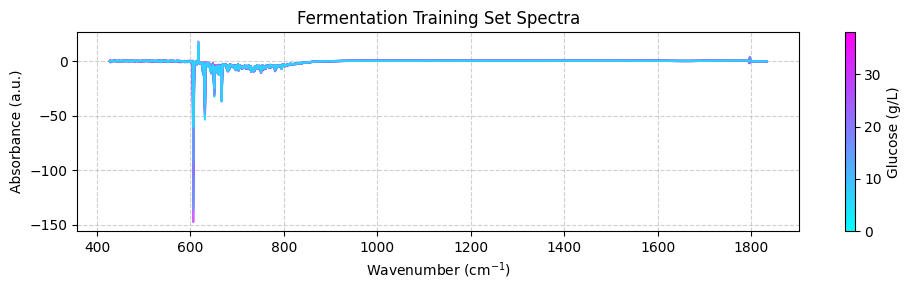

In [7]:
plot_spectra(spectra_np, wavenumbers, hplc_np)

These spectra may look unclear because they cover a wide wavenumber range that includes areas with little chemical information. To get a better view, we should focus on the "fingerprint" region between 950 and 1550 cm<sup>-1</sup>, where the important chemical features appear.
For now, we'll use the zoom_in=True parameter in our plot_spectra() function to focus on this region. Later, we'll learn how to properly trim the spectra using preprocessing functions.

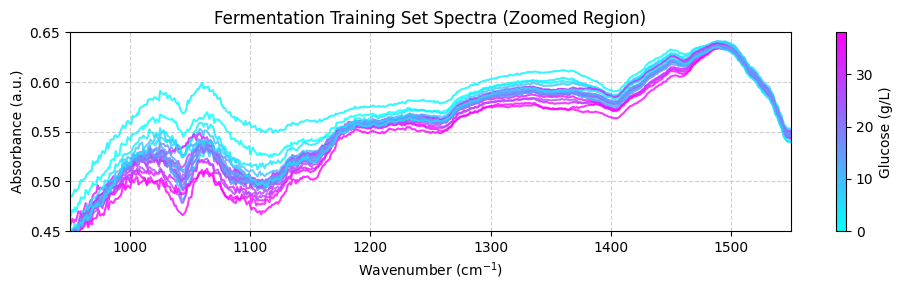

In [8]:
plot_spectra(spectra_np, wavenumbers, hplc_np, zoom_in=True)


## **Preprocessing the training data**
Now that you've explored the dataset, it's time to preprocess the spectral data. This step is essential for removing unwanted variations, such as baseline shifts and noise, which can negatively impact model performance. We'll use the `chemotools` and the `scikit-learn` modules to preprocess the spectral data. 

We will preprocess the spectra using the following steps:
- **[Range Cut](https://paucablop.github.io/chemotools/docs/feature_selection.html#range-cut)**: to remove the wavenumbers outside the range between 950 and 1550 cm<sup>-1</sup>.

- **[Linear Correction](https://paucablop.github.io/chemotools/docs/baseline.html#linear-baseline-correction)**: to remove the linear baseline shift.

- **[Savitzky-Golay](https://paucablop.github.io/chemotools/docs/derivative.html#savitzky-golay-derivative)**: calculates the n<sup>th</sup> order derivative of the spectra using the Savitzky-Golay method. This is useful to remove additive and multiplicative scatter effects.

- **[Standard Scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)**: to scale the spectra to zero mean.

We will chain the preprocessing steps using the [```make_pipeline()```](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html) function from ```scikit-learn```. 

_What is a pipeline?_ A pipeline is a sequence of steps that are executed in a specific order. In our case, we will create a pipeline that will execute the preprocessing steps in the order described above. You can find more information on working with pipelines at our [documentation page](https://paucablop.github.io/chemotools/get-started/scikit_learn_integration.html#working-with-pipelines).

In [9]:
from chemotools.feature_selection import RangeCut
from chemotools.baseline import LinearCorrection
from chemotools.derivative import SavitzkyGolay

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# create a pipeline that scales the data
preprocessing = make_pipeline(
    RangeCut(start=950, end=1500, wavenumbers=wavenumbers),
    LinearCorrection(),
    SavitzkyGolay(window_size=15, polynomial_order=2, derivate_order=1),
    StandardScaler(with_std=False)
)

Now we can use the preprocessing pipeline to preprocess the spectra:

In [10]:
spectra_preprocessed = preprocessing.fit_transform(spectra_np)

And we can use the ```plot_spectra()``` function to plot the preprocessed spectra:

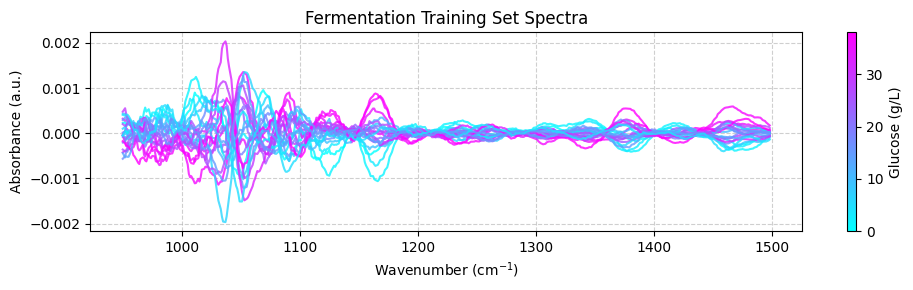

In [11]:
# get the wavenumbers after the range cut
wavenumbers_cut = preprocessing.named_steps['rangecut'].wavenumbers_


# plot the preprocessed spectra
plot_spectra(spectra_preprocessed, wavenumbers_cut, hplc_np)

**This is so cool!**

See how we are integrating chemometrics with scikit-learn? ```RangeCut``` ```LinearCorrection``` and ```SavitizkyGolay``` are all preprocessing techniques implemented in ```chemotools``` while ```StandardScaler``` and ```pipelines``` are functionalities provided by ```scikit-learn``` This is the power of ```chemotools```— it is designed to work seamlessly with ```scikit-learn```

## **Training a PLS model**

Partial Least Squares (PLS) is a powerful regression technique commonly used in chemometrics. It works by finding a latent space representation that maximizes covariance with the target variable.

A critical parameter in PLS modeling is the number of components (dimensions) in the latent space:

- Too many components leads to overfitting, where the model captures noise rather than signal
- Too few components results in underfitting, missing important patterns in the data

When working with limited samples, cross-validation provides a reliable method for selecting the optimal number of components. This approach:

1. Divides the data into training and validation sets
2. Trains the model on the training set and evaluates it on the validation set
3. Repeats this process with different data splits
4. Averages the results to estimate the model's generalization error

For our analysis, we'll use scikit-learn's `GridSearchCV` class to systematically test different component numbers through cross-validation. This will identify the optimal complexity for our PLS model based on performance metrics across multiple data splits.

In [ ]:
# import the PLSRegression and GridSearchCV classes
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV

# instanciate a PLSRegression object
pls = PLSRegression(scale=False)

# define the parameter grid (number of components to evaluate)
param_grid = {'n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

# create a grid search object
grid_search = GridSearchCV(pls, param_grid, cv=10, scoring='neg_mean_absolute_error')

# fit the grid search object to the data
grid_search.fit(spectra_preprocessed, hplc_np)

# print the best parameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", np.abs(grid_search.best_score_))

Best parameters:  {'n_components': 6}
Best score:  0.922944026246299


Suggesting that the optimal number of components is 6, with a mean absolute error of 0.92 g/L. We can verify this by plotting the mean absolute error as a function of the number of components:

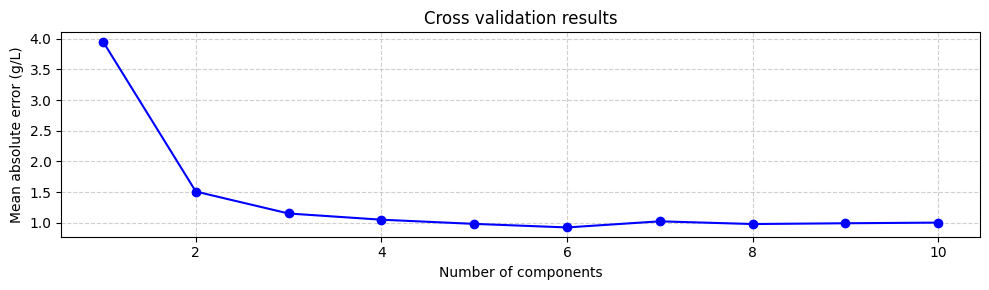

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(param_grid['n_components'], np.abs(grid_search.cv_results_['mean_test_score']), marker='o', color='b')
ax.set_xlabel('Number of components')
ax.set_ylabel('Mean absolute error (g/L)')
ax.set_title('Cross validation results')
ax.grid(True, linestyle='--', alpha=0.6)
fig.tight_layout()

Even though using the number of components that minimize the mean absolute error is a good starting point, it is not always the best. The model with 6 components does not increase the mean absolute error much compared to the model with 3 or even two components. However, the model with 6 components includes components associated with small eigenvalues, which are more uncertain. This means that models with 3 or 2 components might be more robust. Therefore, it is always a good idea to try different numbers of components and select the one that gives the best performance. However, for now we will train the model with 6 components:

In [ ]:
# instanciate a PLSRegression object with 6 components
pls = PLSRegression(n_components=6, scale=False)

# fit the model to the data
pls.fit(spectra_preprocessed, hplc_np)

PLSRegression(n_components=6, scale=False)

Finally we can evaluate the performance of the model on the training set:

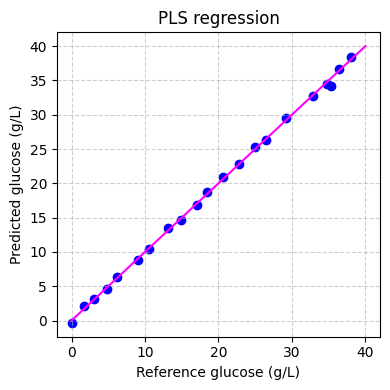

In [ ]:
# predict the glucose concentrations
hplc_pred = pls.predict(spectra_preprocessed)

# plot the predictions
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(hplc_np, hplc_pred, color='blue')
ax.plot([0, 40], [0, 40], color='magenta')
ax.set_xlabel('Reference glucose (g/L)')
ax.set_ylabel('Predicted glucose (g/L)')
ax.set_title('PLS regression')
ax.grid(True, linestyle='--', alpha=0.6)
fig.tight_layout()
plt.show()

## **Applying the model**
Now that we have trained our model, we can apply it to the testing dataset. The testing dataset contains spectra recorded in real-time during the fermentation process. The test dataset contains two `pandas.DataFrame`:

- `spectra`: This dataset contains spectral data, with columns representing wavenumbers and rows representing samples. These spectra were recorded in real-time during the fermentation process approximately every 1.5 minutes.

- `hplc`: This dataset contains HPLC measurements, specifically glucose concentrations (in g/L), stored in a single column labeled `glucose`. These measurements were recorded off-line approximately every 60 minutes.

We will use the `load_fermentation_test()` function from the `chemotools.datasets` module to load the testing dataset:

In [16]:
from chemotools.datasets import load_fermentation_test

spectra_test, hplc_test = load_fermentation_test()

Then, we will preprocess the spectra using the same preprocessing pipeline that we used for the training dataset:

In [17]:
# convert the spectra pandas.DataFrame to numpy.ndarray
spectra_test_np = spectra_test.to_numpy()

# preprocess the spectra
spectra_test_preprocessed = preprocessing.transform(spectra_test_np)

Finally, we can use the PLS model to predict the glucose concentrations:

In [18]:
# predict the glucose concentrations
glucose_test_pred = pls.predict(spectra_test_preprocessed)

We can use the predicted values to plot the spectra color-coded according to the predicted glucose concentrations:

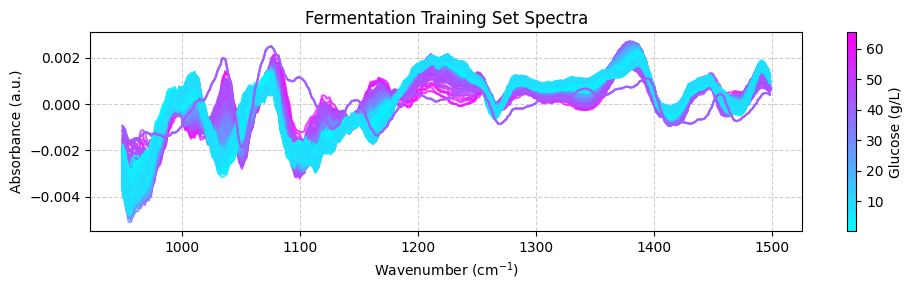

In [19]:
plot_spectra(spectra_test_preprocessed, wavenumbers_cut, glucose_test_pred)

Now we can compare the predicted glucose concentrations with the off-line HPLC measurements. We will plot the predictions and the off-line measurements over time. Each spectrum was taken every 1.25 minutes, while the off-line measurements were taken every 60 minutes.

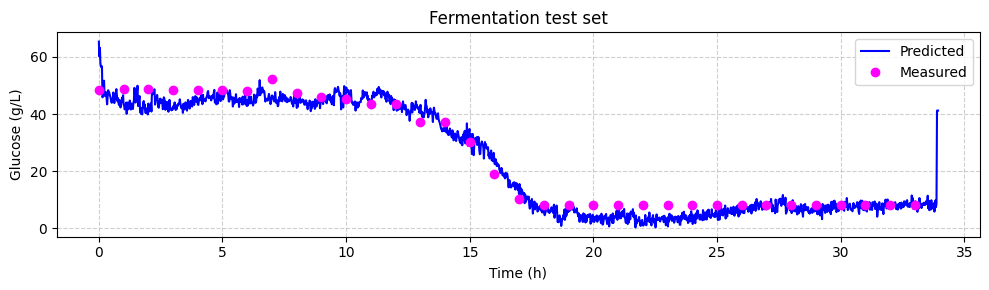

In [20]:
# make linspace of length of predictoins
time = np.linspace(0, len(glucose_test_pred), len(glucose_test_pred),) * 1.25 / 60

# plot the predictions
fig, ax = plt.subplots(figsize=(10, 3))

ax.plot(time, glucose_test_pred,  color='blue', label='Predicted')
ax.plot(hplc_test.index, hplc_test['glucose']+4, 'o', color='fuchsia', label='Measured')
ax.set_xlabel('Time (h)')
ax.set_ylabel('Glucose (g/L)')
ax.set_title('Fermentation test set')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)
fig.tight_layout()
plt.show()

## **Recap**

In this tutorial, we embarked on a journey into the realm of machine learning for spectroscopic data analysis, focusing on the Fermentation dataset. We covered essential steps in building a regression model to predict glucose concentrations during lignocellulosic ethanol fermentation. Here’s a brief recap of what we accomplished:

- **Introduction:** We introduced the Fermentation dataset, which consists of spectral data obtained through attenuated total reflectance, mid-infrared spectroscopy (ATR-MIR), and HPLC reference data. We highlighted the importance of this dataset in understanding real-time fermentation processes.

- **Loading and Exploring Data:** We loaded the training dataset, explored its dimensions, and gained insights into both spectral and HPLC data. Understanding your data is a crucial first step in any data analysis project.

- **Visualizing Data:** We used data visualization to gain a deeper understanding of the dataset. By plotting the spectra color-coded by glucose concentration, we visually examined the chemical variations among samples.

- **Preprocessing Data:** We applied preprocessing techniques, such as range cutting, linear correction, Savitzky-Golay derivative, and standard scaling, to prepare the spectral data for modeling. This step removed unwanted variations and enhanced the data’s quality.

- **Model Training:** We trained a Partial Least Squares (PLS) regression model to predict glucose concentrations. We used cross-validation to find the optimal number of components and assessed model performance.

- **Application to Testing Data:** We extended our model to predict glucose concentrations in real-time by applying it to the testing dataset. This allowed us to monitor glucose levels during fermentation.

This tutorial provides a solid foundation for anyone interested in using machine learning techniques for spectroscopic data analysis. By following these steps, you can gain valuable insights from complex spectral data and make predictions that can be applied in real-world applications. Happy analyzing!